# Decision Trees

Let's now calculate the hypotenus of the Treeangle using decision Triis. (yolo) <br>

This is yet another beautiful logic. We narrow down the possible outcomes by asking binary questions like; is side a larger than 10? If yes, we go to one direction if not we go to the other. If we keep asking these; "is side-a that", "is side-b this", "is angle that" kind of questions, we eventually learn where side-c's end up.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
import pandas as pd 
import sys, os
import matplotlib.pyplot as plt

# Add the project root to sys.path (one level up from this notebook)
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from hypotai.data import generate_triangle_data
from hypotai.plotting import plot_triangle

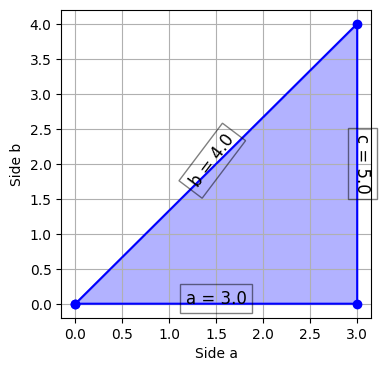

In [3]:
plot_triangle(3,4)

In [14]:
df = generate_triangle_data(n_samples=10_000, angle_mode="right")
X = df[["a", "b"]]
y = df["c"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 22.13297888619101
R²: 0.9721609647175636


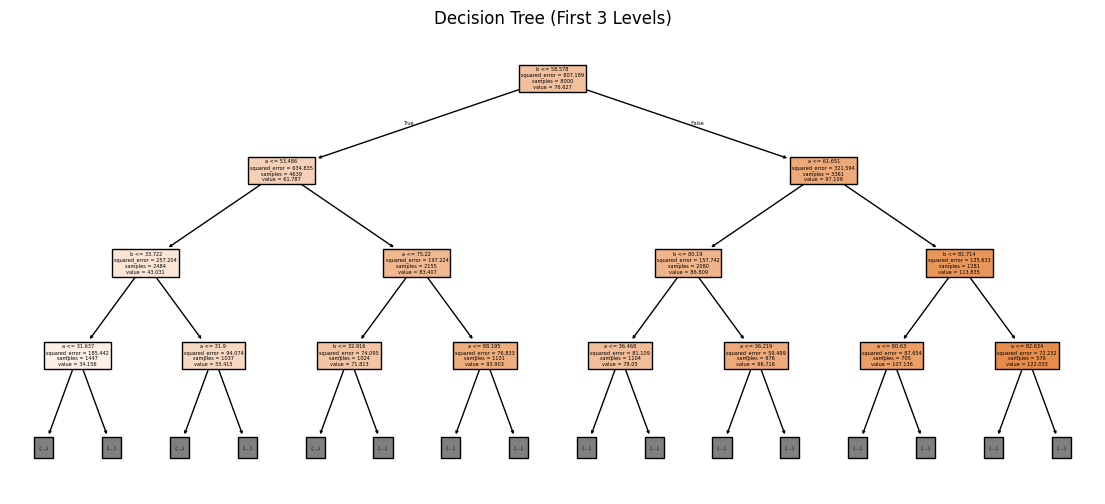

In [16]:
from sklearn.tree import plot_tree

plt.figure(figsize=(14, 6))
plot_tree(tree, feature_names=["a", "b"], filled=True, max_depth=3)
plt.title("Decision Tree (First 3 Levels)")
plt.show()


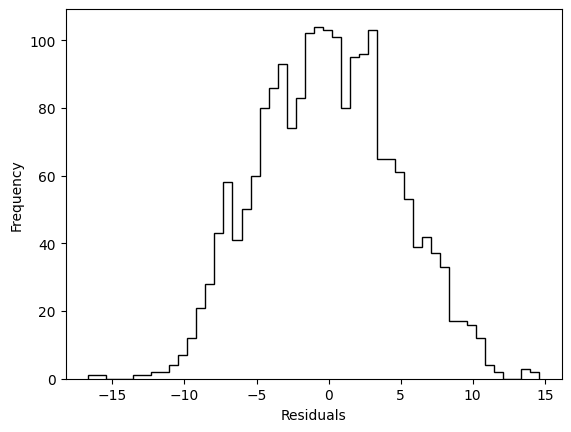

In [17]:
plt.hist(y_test - y_pred, bins=50, color='k', histtype='step', label='Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency');

You see. It is that simple! Let's look at when the angles are randomized and then talk about a **very fancy thing** Hyperparameter-tuning wooo.

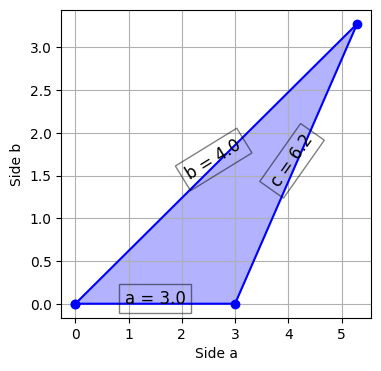

In [10]:
plot_triangle(3,4, angle=125)

MSE: 156.62430583761855
R²: 0.8896603468267958


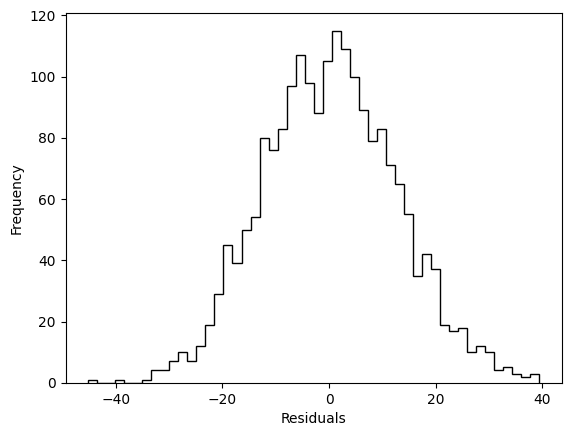

In [19]:
df_angle = generate_triangle_data(n_samples=10_000, angle_mode="random")
### I will also pass the angle as a feature
X = df_angle[["a", "b", "angle_deg"]]
y = df_angle["c"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

plt.hist(y_test - y_pred, bins=50, color='k', histtype='step', label='Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency');

Compared to right angle triangles, the performance seems to be bad. Can we improve this? There are a few things we can do. 

In [20]:
DecisionTreeRegressor??

Init signature:
DecisionTreeRegressor(
    *,
    criterion='squared_error',
    splitter='best',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    ccp_alpha=0.0,
    monotonic_cst=None,
)
Source:        
class DecisionTreeRegressor(RegressorMixin, BaseDecisionTree):
    """A decision tree regressor.

    Read more in the :ref:`User Guide <tree>`.

    Parameters
    ----------
    criterion : {"squared_error", "friedman_mse", "absolute_error", \
            "poisson"}, default="squared_error"
        The function to measure the quality of a split. Supported criteria
        are "squared_error" for the mean squared error, which is equal to
        variance reduction as feature selection criterion and minimizes the L2
        loss using the mean of each terminal node, "friedman_mse", which uses
        mean squared error with Frie

The decision tree internally does some smart things ("black box", let's call it semi-transparent). <br>

It already defines, how to tell if a split was good or bad. It also tries a several split and finds the one that gives you the most insight and prunes the other ones. You can play with some of these parameters to see if you can get a better performance. Hence the term; "Hyperparameter Tuning".

In [22]:
for md in [1, 3, 5, 7, 10]:
    tree = DecisionTreeRegressor(max_depth=md, random_state=42)
    tree.fit(X_train, y_train)

    y_pred = tree.predict(X_test)

    print("\nMax Depth:", md)
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))


Max Depth: 1
MSE: 1018.9143547986598
R²: 0.282188955791814

Max Depth: 3
MSE: 410.291762923156
R²: 0.7109551382931645

Max Depth: 5
MSE: 156.62430583761855
R²: 0.8896603468267958

Max Depth: 7
MSE: 61.42322786317812
R²: 0.9567281870910361

Max Depth: 10
MSE: 20.68859503130229
R²: 0.9854251714752278


Or similarly, we could have played with the `min_samples_leaf` which sets the minimum number of samples to leave in each leaf after the final split. 

In [26]:
for msl in [50, 100, 1000, 2000]:
    tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=msl, random_state=42)
    tree.fit(X_train, y_train)

    y_pred = tree.predict(X_test)

    print("\nMin Samples Leaf:", msl)
    print("MSE:", mean_squared_error(y_test, y_pred))
    print("R²:", r2_score(y_test, y_pred))


Min Samples Leaf: 50
MSE: 156.62430583761855
R²: 0.8896603468267958

Min Samples Leaf: 100
MSE: 157.83320762446374
R²: 0.8888086922693017

Min Samples Leaf: 1000
MSE: 455.0995437650316
R²: 0.679388677576146

Min Samples Leaf: 2000
MSE: 774.1620242047461
R²: 0.45461358124595275


So it looks like, if you want to have like a 1000 sample in the final node (the data had 10k in the beginning) you did not split things efficiently (a.k.a. **Underfitting**).

The inverse of this; i.e. splitting things until every sample sits on 1 single leaf is called **Overfitting** imagine that as dividing a square into smaller squares that represent a distribution, but instead of enclosing the distribution itself you are boxing each data point. Below is an example of a good fit. If we further split these 2 boxes by asking more "is x larger than 10" kind of questions, we will start to *lose* the generic behaviour (i.e. underlying distribution) and start overfitting onto individual data points.

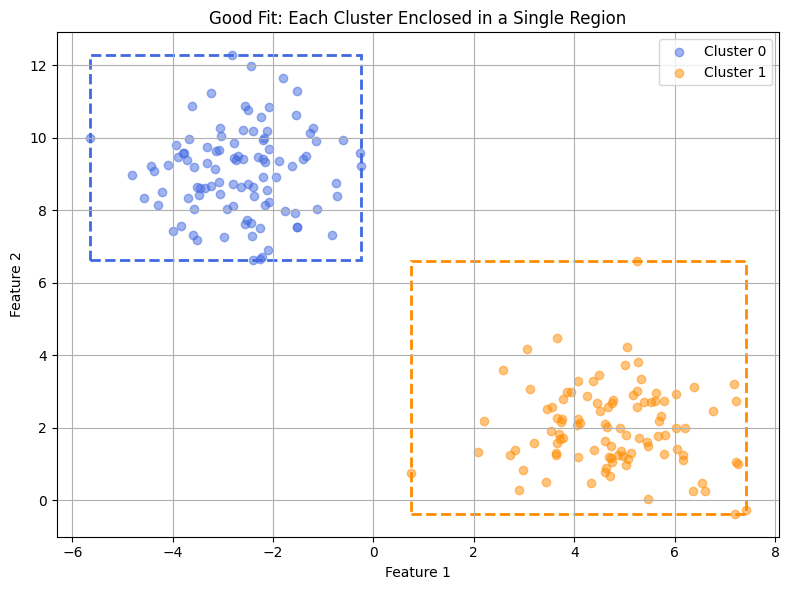

In [27]:
from sklearn.datasets import make_blobs
from matplotlib.patches import Rectangle

# Create two 2D Gaussian blobs
X, y = make_blobs(n_samples=200, centers=2, cluster_std=1.2, random_state=42)

# Plot the data
plt.figure(figsize=(8, 6))
colors = ["royalblue", "darkorange"]

for class_id in np.unique(y):
    class_points = X[y == class_id]
    plt.scatter(class_points[:, 0], class_points[:, 1], alpha=0.5, label=f"Cluster {class_id}", color=colors[class_id])

    # Compute bounding box
    x_min, x_max = class_points[:, 0].min(), class_points[:, 0].max()
    y_min, y_max = class_points[:, 1].min(), class_points[:, 1].max()

    # Draw rectangle
    rect = Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                     linewidth=2, edgecolor=colors[class_id], facecolor='none', linestyle="--")
    plt.gca().add_patch(rect)

plt.title("Good Fit: Each Cluster Enclosed in a Single Region")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Okay, but how do I know which parameters to use?

That is the "doing machine learning" part. Grid Scan helps with checking different parameter combinations, but ultimately the final tuned model should work on any new dataset.

sklearn conveniently has this gridsearch functionality (for a few degree we could've also run loops and do the same).

In [28]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_leaf": [1, 5, 10]
}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring="r2")
grid.fit(X_train, y_train)

print(grid.best_params_)
print(grid.best_score_)

{'max_depth': None, 'min_samples_leaf': 1}
0.9898540876954783


We can also bundle a bunch of DecisionTree and create a **Forest** <br>

A Random Forest is an ensemble of Decision Trees, where each tree:<br>
 - is trained on a random subset of the data (bootstrapping),
 - and each split considers a random subset of features.

This way, it improves generalization (it randomizes for each tree), can capture nonlinear effects, and reduces overfitting since what it learns from keeps changing.

Thus it actually makes more sense with a higher dimensional data, but you only live ones. Let's make our lives more complicated. Simplicity is overrated.